In [1]:
%pylab inline
from scipy.spatial.distance import cdist

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def find_dists(X,rep):
    C=cdist(X,rep)
    index=argmin(C,axis=1)
    dist=np.min(C,axis=1)
    return index,dist

def find_cover_iter(rep,X,epsilon=1,debug=False) :
    m=X.shape[0]
    found=False
    for i in range(m):
        x=X[i:i+1,:]  # can make more efficient by checking several at once and keeping 
                      # track of the location of the last find.
        _,dist=find_dists(x,rep)
        if np.min(dist)>epsilon:
            if debug:
                print(i,np.min(dist),rep.shape)
            rep=concatenate([rep,x],axis=0)
            found=True
    return rep,found

def source(m,n):
    " a generator of example batches"
    while True:
        yield (rand(m,n)*2)-1

def find_cover(rep,source,epsilon=1,debug=False):
    found=True; j=0
    cover=rep
    for X in source():
        cover,found=find_cover_iter(cover,X,epsilon=epsilon,debug=debug)
        if debug:
            print('### round ',j,cover.shape); j+=1
        if not found:
            break
    return cover

def split(X,cover):
    """ Partition rows in X according to the cclosest row in cover"""
    index,dist = find_dists(X,cover)
    
    subset=[]
    for i in range(cover.shape[0]):
        s=X[nonzero(index==i),:]
        subset.append(s[0,:,:])
    return subset

In [3]:
n=2;
m=3
rep=eye(n)
X=concatenate([eye(n)*(1+0.1*i) for i in range(m)],axis=0)
X.shape

(6, 2)

In [4]:
X

array([[1. , 0. ],
       [0. , 1. ],
       [1.1, 0. ],
       [0. , 1.1],
       [1.2, 0. ],
       [0. , 1.2]])

In [5]:
index,dist = find_dists(X,rep)

In [6]:
index

array([0, 1, 0, 1, 0, 1])

In [7]:
dist

array([0. , 0. , 0.1, 0.1, 0.2, 0.2])

### finding a cover

In [27]:
%%time
n=2
rep=array([zeros(n)])
rep.shape
epsilon=0.2
m=10000

def source():
    while True:
        yield (rand(m,n)*2)-1
        
cover=find_cover(rep,source,epsilon=epsilon)

CPU times: user 236 ms, sys: 8.65 ms, total: 244 ms
Wall time: 248 ms


In [28]:
cover.shape

(78, 2)

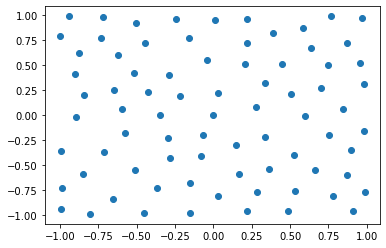

In [29]:
scatter(cover[:,0],cover[:,1])

### Split Examples

In [11]:
X=source().__next__()


index.shape, X.shape

((6,), (10000, 2))

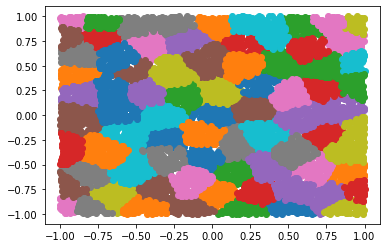

In [30]:
subset=split(X,cover)

for s in subset:
    scatter(s[:,0],s[:,1])

In [13]:
data=[]
j=0
for x in source():
    break
x.shape

(10000, 2)

In [14]:
x.dump('square.npy')

In [15]:
!ls -l square.npy

-rw-r--r--  1 yoavfreund  staff  250285 Jul 19 12:26 square.npy


In [16]:
import numpy as np
from scipy.spatial import distance_matrix
from scipy.stats import norm
from sklearn.neighbors import BallTree

In [39]:
class MatrixIterator:
    
    def __init__(self,centers, source_radius, source, Cg=1.0,sigma=0.5,iterations=1000,tolerance=1e-4):
        #dim=1    #dimension of space                                                                                                                                                            
        #n = 10  #number of samples                                                                                                                                                              
        #sigma=0.2  #width of Gaussian                                                                                                                                                           
        #iterations=10 # number of iteration of averaging recursion                                                                                                                              
        #_tolerance = 1e-4 # stop afteer error is below _tolerance
        self.centers=centers
        (n, dim) = centers.shape
        self.n=n
        self.dim = dim
        
        self.sigma = sigma
        self.Cg = Cg
        self.iterations=iterations
        self.tolerance=tolerance
        self.set_sources(source_radius, source)
        
    def set_sources(self, source_radius, source):
        tree = BallTree(self.centers)
        print(source)
        print(self.centers)
        self.ind = tree.query_radius([source], source_radius)[0]

    def make_transition_matrix(self):
        # compute recursion matrix (W)                                                                                                                                                       
        A=distance_matrix(self.centers, self.centers)
        Adgacency=norm.pdf(A,scale=self.sigma)
        W=Adgacency/(sum(Adgacency,axis=1)+self.Cg)
        return W
    
    def solve(self):
        vec = np.zeros(self.n)
        np.put(vec, self.ind, 1.)
        W = self.make_transition_matrix()
        for i in range(self.iterations):
            vec = np.dot(W, vec)
            np.put(vec, self.ind, 1.)
        return vec


In [40]:
%%time
mat_it = MatrixIterator(cover, 0.1, cover[0])

[0. 0.]
[[ 0.          0.        ]
 [-0.90298399  0.41143435]
 [ 0.1642206  -0.58949859]
 [-0.73276624  0.76885212]
 [-0.84610395  0.20567318]
 [ 0.28041575  0.07862435]
 [-0.44461115  0.7209833 ]
 [ 0.14928662 -0.29436042]
 [ 0.02935033  0.22578508]
 [ 0.3384806  -0.21438436]
 [-0.29796515 -0.23074853]
 [ 0.87215592 -0.60190516]
 [-0.21988448  0.19221719]
 [ 0.21725354  0.72160224]
 [-0.15775941  0.77000622]
 [-0.36439109 -0.73381564]
 [ 0.87353516  0.7230482 ]
 [-0.87373564  0.6229739 ]
 [-0.65714269 -0.83818925]
 [-0.57751421 -0.17809584]
 [ 0.4887696  -0.96383429]
 [ 0.03159228 -0.80792459]
 [ 0.21591477 -0.96477652]
 [ 0.75236758 -0.19568512]
 [ 0.84453125  0.05918911]
 [-0.89677085 -0.0190313 ]
 [-0.99520083 -0.9364965 ]
 [-0.84671777 -0.5843253 ]
 [ 0.96580966  0.97177587]
 [-0.50886373 -0.55313005]
 [ 0.33506739  0.32667129]
 [-0.71242941 -0.36485993]
 [ 0.58652306  0.86871468]
 [ 0.69831398  0.26741113]
 [ 0.77751757 -0.8106528 ]
 [-0.51959754  0.42157516]
 [ 0.6641709  -0.551

In [41]:
matrix = mat_it.make_transition_matrix()
matrix.shape

(78, 78)

In [42]:
voltages = mat_it.solve()

In [44]:
voltages

array([1.        , 0.1205876 , 0.17836086, 0.11774601, 0.13548481,
       0.21354415, 0.14877914, 0.21075524, 0.21888247, 0.20394228,
       0.2050299 , 0.11196934, 0.21515377, 0.15812806, 0.15301621,
       0.14451749, 0.10352767, 0.11356357, 0.1071666 , 0.17528501,
       0.10677799, 0.14588151, 0.11688253, 0.15172876, 0.13916083,
       0.12602893, 0.06521577, 0.11033894, 0.06951204, 0.15526831,
       0.1976646 , 0.14486337, 0.11573034, 0.15863869, 0.10404064,
       0.17482495, 0.14371737, 0.11530033, 0.12336526, 0.20851377,
       0.20124191, 0.1233222 , 0.17170963, 0.10061334, 0.17903183,
       0.18645912, 0.07325471, 0.18906984, 0.19590031, 0.11807733,
       0.17754626, 0.18739243, 0.1380425 , 0.14663825, 0.1749089 ,
       0.11440956, 0.16440068, 0.17356588, 0.07416565, 0.10709831,
       0.14805802, 0.10247678, 0.11149722, 0.08400054, 0.13334421,
       0.08441983, 0.18708426, 0.1179037 , 0.11401453, 0.13486565,
       0.16684543, 0.21927132, 0.09282184, 0.13654779, 0.19653

In [48]:
subset=split(X,cover)
i = 0
colors=[int(voltages[*30) for x in voltages]
X.shape

(10000, 2)

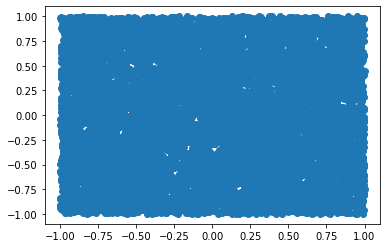

In [50]:
scatter(X[:,0],X[:,1])

ValueError: 'c' argument has 1 elements, which is inconsistent with 'x' and 'y' with size 156.

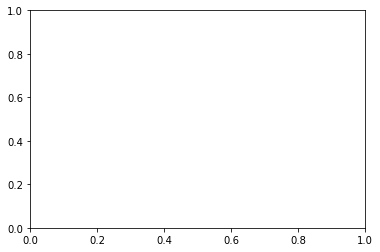

In [45]:
for s in subset:
    scatter(s[:,0],s[:,1],c= volts[i])
    i+=1